### Distances 100 shapley points - 6 class training

#### Environment preparation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

COLAB_ROOT = '/content/drive/MyDrive/PainRecognitionProject/'
print(f"Dane będą wczytywane z: {COLAB_ROOT}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Dane będą wczytywane z: /content/drive/MyDrive/PainRecognitionProject/


In [ ]:
import os

%cd /content

!rm -rf automatic-pain-recognition

print(f"Obecne położenie: {os.getcwd()}")

/content
Obecne położenie: /content


In [ ]:
USERNAME = 'alicka33'
REPO_NAME = 'automatic-pain-recognition'

REPO_URL = f"https://github.com/{USERNAME}/{REPO_NAME}.git"

print("Rozpoczynam klonowanie...")

!git clone {REPO_URL}

%cd $REPO_NAME

Rozpoczynam klonowanie...
Cloning into 'automatic-pain-recognition'...
remote: Enumerating objects: 246, done.
remote: Counting objects: 100% (246/246), done.
remote: Compressing objects: 100% (194/194), done.
remote: Total 246 (delta 111), reused 181 (delta 48), pack-reused 0 (from 0)
Receiving objects: 100% (246/246), 10.95 MiB | 15.67 MiB/s, done.
Resolving deltas: 100% (111/111), done.
/content/automatic-pain-recognition


In [ ]:
!pip install -r requirements.txt

In [ ]:
import sys
import os

sys.path.append(os.getcwd())
print(f"Dodano do ścieżki Pythona: {os.getcwd()}")

Dodano do ścieżki Pythona: /content/automatic-pain-recognition


#### Distances 100 shapley points - 6 class training

In [52]:
import os
import numpy as np
import pandas as pd
import shutil

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from training_utils.preprocessed_dataset import PreprocessedDataset
from training_utils.train import Trainer
from training_utils.evaluate import Evaluator
from models.Bi_LSTM import SequenceModel

#### Hiperparameters

In [53]:
MAX_SEQUENCE_LENGTH = 37
NUM_FEATURES = 100
NUM_CLASSES = 6
HIDDEN_SIZE = 32           # Reduced further from 64 (much simpler model)
NUM_LAYERS = 1             # Keep at 1 layer
NUM_EPOCHS = 150           # Reduced from 200 (early stopping will handle it)
BATCH_SIZE = 32            # Keep larger batches
LEARNING_RATE = 0.001      # Keep at 0.001
DROPOUT_PROB = 0.7         # Increased from 0.6 (stronger regularization)
WEIGHT_DECAY = 0.02        # Increased from 0.01 (more L2 regularization)
SCHEDULER_FACTOR = 0.5     # Keep aggressive LR reduction
SCHEDULER_PATIENCE = 12

#### Data preparation

In [8]:
COLAB_ROOT = '/content/drive/MyDrive/PainRecognitionProject/'
PROCESSED_DATA_DIR = os.path.join(COLAB_ROOT, 'data/RAVDESS_processed_478_xyz_frontalized/')
MODEL_SAVE_DIR = os.path.join(COLAB_ROOT, 'models/')
LOCAL_PROCESSED_DATA_ROOT = '/content/temp_data/'

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
print("Kopiowanie danych z Google Drive do lokalnej pamięci Colab (RAM)...")
if os.path.exists(LOCAL_PROCESSED_DATA_ROOT):
    shutil.rmtree(LOCAL_PROCESSED_DATA_ROOT)
try:
    shutil.copytree(PROCESSED_DATA_DIR, LOCAL_PROCESSED_DATA_ROOT)
    print("✅ Kopiowanie zakończone pomyślnie. Czas trwania: (sprawdź zegar)")
    CURRENT_DATA_DIR = LOCAL_PROCESSED_DATA_ROOT

except Exception as e:
    print(f"❌ Błąd kopiowania danych (sprawdź, czy dane są zamontowane): {e}")
    print("Używam danych bezpośrednio z Drive (może się zawiesić).")
    CURRENT_DATA_DIR = PROCESSED_DATA_DIR

Kopiowanie danych z Google Drive do lokalnej pamięci Colab (RAM)...
✅ Kopiowanie zakończone pomyślnie. Czas trwania: (sprawdź zegar)


In [43]:
best_100 = np.load('/content/drive/MyDrive/PainRecognitionProject/data/top_100_important_landmarks_emotions.npy')

In [44]:
train_dataset = PreprocessedDataset(
    'train',
    processed_data_dir=CURRENT_DATA_DIR,
    indices=best_100,
    compute_euclidean=True,
    center_point_index=2,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    selected_labels=[2, 3, 4, 5, 6, 8],
    label_map={2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 8: 5},
)

val_dataset = PreprocessedDataset(
    'val',
    processed_data_dir=CURRENT_DATA_DIR,
    indices=best_100,
    compute_euclidean=True,
    center_point_index=2,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    selected_labels=[2, 3, 4, 5, 6, 8],
    label_map={2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 8: 5},
)

test_dataset = PreprocessedDataset(
    'test',
    processed_data_dir=CURRENT_DATA_DIR,
    indices=best_100,
    compute_euclidean=True,
    center_point_index=2,
    max_sequence_length=MAX_SEQUENCE_LENGTH,
    selected_labels=[2, 3, 4, 5, 6, 8],
    label_map={2: 0, 3: 1, 4: 2, 5: 3, 6: 4, 8: 5},
)

In [54]:
def preview_single(dataset, idx=0, timesteps_to_show=3, features_to_show=8):
    x, y = dataset[idx]
    print(f"\nSingle sample idx={idx} from split={dataset.dataset_name}")
    print(f"x shape: {tuple(x.shape)}, y: {y}")
    print(np.round(x[:timesteps_to_show, :features_to_show], 4))

preview_single(train_dataset, 0)
preview_single(val_dataset, 0)
preview_single(test_dataset, 0)


Single sample idx=0 from split=train
x shape: (37, 100), y: 0
tensor([[0.2004, 0.2422, 0.1642, 0.1752, 0.1809, 0.1882, 0.1701, 0.2231],
        [0.1973, 0.2360, 0.1626, 0.1764, 0.1766, 0.1833, 0.1658, 0.2216],
        [0.1961, 0.2359, 0.1618, 0.1762, 0.1767, 0.1835, 0.1656, 0.2211]])

Single sample idx=0 from split=val
x shape: (37, 100), y: 0
tensor([[0.2235, 0.2754, 0.1782, 0.1783, 0.1996, 0.2145, 0.1828, 0.2463],
        [0.2210, 0.2703, 0.1766, 0.1775, 0.1968, 0.2114, 0.1818, 0.2443],
        [0.2186, 0.2695, 0.1744, 0.1756, 0.1931, 0.2075, 0.1772, 0.2418]])

Single sample idx=0 from split=test
x shape: (37, 100), y: 0
tensor([[0.2100, 0.2658, 0.1665, 0.1652, 0.1967, 0.2125, 0.1877, 0.2303],
        [0.2117, 0.2679, 0.1670, 0.1654, 0.1955, 0.2127, 0.1855, 0.2315],
        [0.2128, 0.2720, 0.1677, 0.1661, 0.1971, 0.2137, 0.1880, 0.2326]])


In [55]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
for X, y in train_loader:
    print(X.shape, y.shape)  # (B, T_max, num_features)
    break

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
for X, y in val_loader:
    print(X.shape, y.shape)  # (B, T_max, num_features)
    break

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
for X, y in test_loader:
    print(X.shape, y.shape)  # (B, T_max, num_features)
    break

torch.Size([32, 37, 100]) torch.Size([32])
torch.Size([32, 37, 100]) torch.Size([32])
torch.Size([32, 37, 100]) torch.Size([32])


#### Model preparation

In [56]:
model = SequenceModel(NUM_FEATURES, HIDDEN_SIZE, NUM_LAYERS, NUM_CLASSES, DROPOUT_PROB).to(DEVICE)

/usr/local/lib/python3.12/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.7 and num_layers=1
  warnings.warn(


#### Training

In [58]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=SCHEDULER_FACTOR,
    patience=SCHEDULER_PATIENCE,
    min_lr=1e-7
)

model_name = 'testing_new_code_emotions_100_distances_6_classes_hiper_hidd_32_1.pt'
model_filepath = os.path.join(MODEL_SAVE_DIR, model_name)

In [59]:
trainer = Trainer(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    device=DEVICE,
    model_save_path=model_filepath,
    num_epochs=NUM_EPOCHS,
    monitor='val_acc',  # or 'val_loss'
    minimize_monitor=False,
    save_best_only=True
)

In [60]:
trainer.print_training_config()



🚀 TRAINING CONFIGURATION

--- Model Architecture ---
  Model Type            : SequenceModel
  Input Features        : 100
  Hidden Size           : 32
  Num Layers            : 1
  Bidirectional         : True
  Dropout (LSTM)        : 0.7
  Num Parameters        : 34694

--- Optimizer & Regularization ---
  Optimizer             : AdamW
  Learning Rate (LR)    : 0.001
  Weight Decay (L2)     : 0.02

--- Training Flow ---
  Batch Size            : 32
  Num Epochs            : 150
  Device                : cuda



In [61]:
final_model_path, best_model_path, history = trainer.fit()
print(f"Final model saved to: {final_model_path}")
if best_model_path:
    print(f"Best model saved to: {best_model_path}")


Starting training for 150 epochs on cuda
Saved best model to /content/drive/MyDrive/PainRecognitionProject/models/best_testing_new_code_emotions_100_distances_6_classes_hiper_hidd_32_1.pt (metric=0.1671)
Epoch 1/150 | Time 2.25s | Train loss 1.8015 | Train acc 0.1543 | Val loss 1.7920 | Val acc 0.1671
Saved best model to /content/drive/MyDrive/PainRecognitionProject/models/best_testing_new_code_emotions_100_distances_6_classes_hiper_hidd_32_1.pt (metric=0.1958)
Epoch 2/150 | Time 2.26s | Train loss 1.7985 | Train acc 0.1725 | Val loss 1.7921 | Val acc 0.1958
Epoch 3/150 | Time 2.25s | Train loss 1.7936 | Train acc 0.1562 | Val loss 1.7905 | Val acc 0.1854
Saved best model to /content/drive/MyDrive/PainRecognitionProject/models/best_testing_new_code_emotions_100_distances_6_classes_hiper_hidd_32_1.pt (metric=0.2507)
Epoch 4/150 | Time 2.74s | Train loss 1.7941 | Train acc 0.1504 | Val loss 1.7896 | Val acc 0.2507
Epoch 5/150 | Time 2.52s | Train loss 1.7865 | Train acc 0.1868 | Val loss

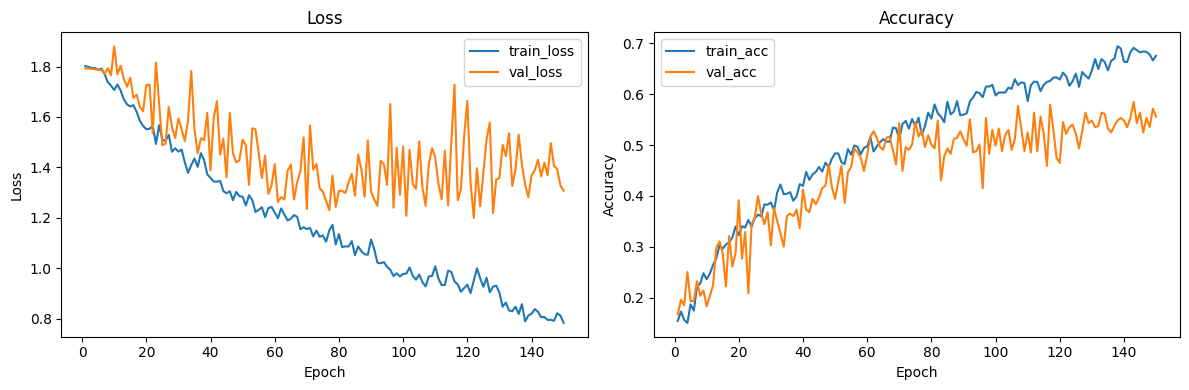

In [62]:
trainer.plot_history()

#### Evaluate

In [63]:
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE), strict=False)

<All keys matched successfully>

In [64]:
evaluator = Evaluator(model, test_loader, device=DEVICE, model_name=model_name, num_classes=NUM_CLASSES)


In [65]:
loss, acc, labels, preds = evaluator.evaluate_epoch()


WYNIKI OCENY DLA MODELU: testing_new_code_emotions_100_distances_6_classes_hiper_hidd_32_1.pt
Test Loss: 1.3008
Test Accuracy: 0.5156

--- Szczegółowy Raport Klasyfikacji ---
              precision    recall  f1-score   support

     Klasa 0       0.73      0.59      0.66        64
     Klasa 1       0.95      0.56      0.71        64
     Klasa 2       0.40      0.72      0.52        64
     Klasa 3       0.71      0.53      0.61        64
     Klasa 4       0.33      0.38      0.35        64
     Klasa 5       0.34      0.31      0.33        64

    accuracy                           0.52       384
   macro avg       0.58      0.52      0.53       384
weighted avg       0.58      0.52      0.53       384

Confusion matrix:
 [[38  0 22  0  2  2]
 [10 36  2  0  0 16]
 [ 2  0 46  8  8  0]
 [ 0  0  2 34 21  7]
 [ 2  0 20  4 24 14]
 [ 0  2 22  2 18 20]]
